In [11]:
import torch
from torch.utils.data import DataLoader
import os 
import cv2


In [12]:
from torchvision import transforms

def load_images(image_folder):
    images = {}
    for filename in os.listdir(image_folder):
        if filename.endswith('_test.jpg'):
            file_id = filename.split('_')[0]
            full_path = os.path.join(image_folder, filename)
            image = cv2.imread(full_path)  
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
            image_tensor = transforms.ToTensor()(image)  
            images[file_id] = {"image": image_tensor}
    return images

In [13]:
def parse_annotations_yolo(annotation_folders):
    annotations = {}
    for file in os.listdir(annotation_folders):
        if file.endswith('.txt'):
            file_id = os.path.splitext(file)[0]
            file_path = os.path.join(annotation_folders, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                bbox_data = []
                for line in lines:
                    x1, y1, x2, y2, class_label = map(int, line.split())
                    width = x2 - x1
                    height = y2 - y1
                    x_center = (x1 + x2) / 2
                    y_center = (y1 + y2) / 2
                    image_width = 1.0
                    image_height = 1.0
                    x_center /= image_width
                    y_center /= image_height
                    width /= image_width
                    height /= image_height
                    bbox_data.append([class_label, x_center, y_center, width, height]) 

                bbox_tensor = torch.tensor(bbox_data, dtype=torch.float32) 
                annotations[file_id] = {"annotation":bbox_tensor}
    return annotations


In [14]:
annotations = parse_annotations_yolo("C:/Users/DARYL/Schoolwork/FYP/Surface-Defect-Detection/DeepPCB/PCBData/combined_group/images_not")
dataset_image = load_images("C:/Users/DARYL/Schoolwork/FYP/Surface-Defect-Detection/DeepPCB/PCBData/combined_group/images")

# Merge the dictionaries
merged_dict = {img_id: (dataset_image[img_id], annotations[img_id]) for img_id in dataset_image if img_id in annotations}


In [15]:
print(merged_dict)

{'00041000': ({'image': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])}, {'annotation': tensor([[  3.0000, 479.5000, 455.5000,  27.0000,  29.0000],
        [  2.0000, 473.5000, 348.0000,  39.0000,  96.0000],
        [  4.0000, 347.5000, 265.5000,  33.0000,  35.

In [16]:
from torch.utils.data import Dataset

class PCBDefectDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (dict): A dictionary where keys are image IDs and values are tuples,
                         with the first element being the image tensor and the second
                         being the annotation dictionary containing 'boxes' and 'labels'.
            transform (callable, optional): Optional transform to be applied on the image.
        """
        self.data = data
        self.ids = list(data.keys())  
        self.transform = transform 

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        image, targets = self.data[img_id] 
        if self.transform:
            image = self.transform(image)  
        return image, targets


In [17]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

def collate_fn(batch):
    images, annotations = zip(*batch)
    return list(images), list(annotations) 

from torch.utils.data import DataLoader, random_split

# Assuming PCBDefectDataset is defined and merged_dict is available
dataset = PCBDefectDataset(merged_dict, transform=None)

# Calculate lengths for splits
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% of dataset
validate_size = int(0.15 * total_size)  # 15% of dataset
test_size = total_size - train_size - validate_size  # Remaining data for testing

# Split the dataset
train_dataset, validate_dataset, test_dataset = random_split(dataset, [train_size, validate_size, test_size])

batch_s = 4
# Create DataLoader for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True, collate_fn=collate_fn)
validate_loader = DataLoader(validate_dataset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)

# test image 
subset_indices = [0,1]
train_subset = Subset(dataset, subset_indices)
train_loader_single = DataLoader(train_subset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)

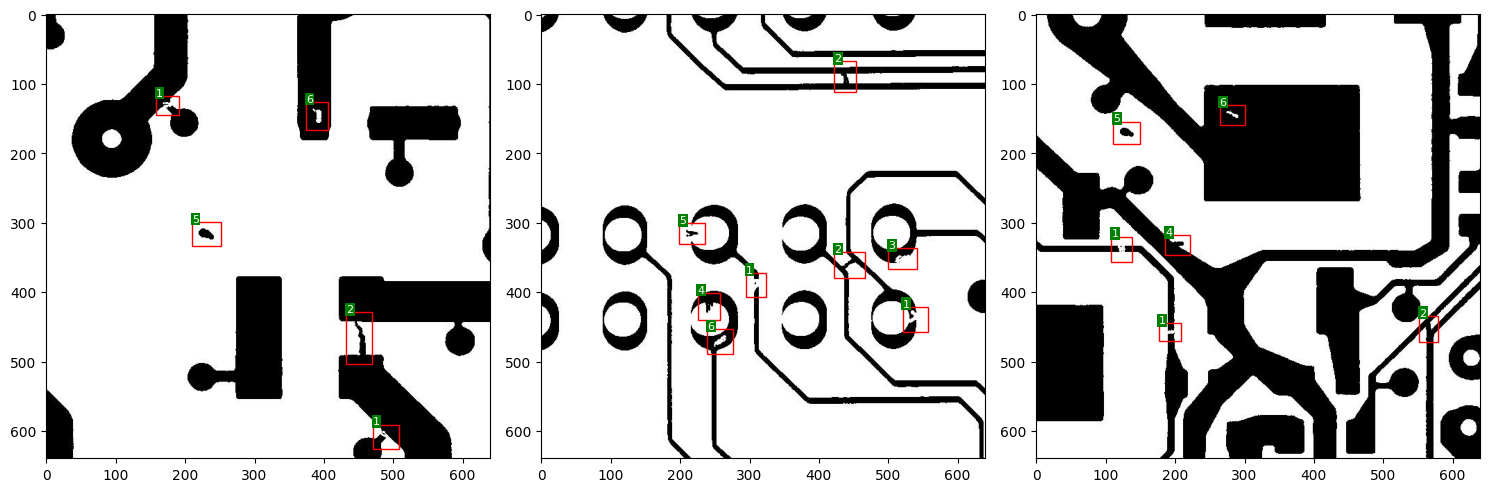

In [18]:
import matplotlib.pyplot as plt
from matplotlib import patches

num_images_to_display = 3

fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):

    data_item= train_dataset[i]
    image_tensor = data_item[0]["image"]
    annotations = data_item[1]["annotation"]
    # print(annotations)
    image_np = image_tensor.permute(1, 2, 0).numpy()
    
    ax = axs[i]
    ax.imshow(image_np)
    
    for annotation in annotations:
        # print(annotation)
        class_label, x_center, y_center, width, height = annotation
        x_min = (x_center - width / 2) 
        y_min = (y_center - height / 2)
        bbox_width = width 
        bbox_height = height 
        rect = patches.Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{int(class_label)}', color='white', fontsize=8, 
                bbox=dict(facecolor='green', edgecolor='none', pad=1))

    ax.axis('on')

plt.tight_layout()
plt.show()


In [19]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')


In [20]:
def freeze_layers(model):
    for name, param in model.named_parameters():
        if 'backbone' in name: # Adjust the condition based on the layers you want to freeze
            param.requires_grad = False


In [27]:
import os
import torch

def convert_to_yolo(annotation_folders, output_folder):
    for file in os.listdir(annotation_folders):
        if file.endswith('.txt'):
            file_id = os.path.splitext(file)[0]
            file_path = os.path.join(annotation_folders, file)
            output_file_path = os.path.join(output_folder, file)
            
            with open(file_path, 'r') as f:
                lines = f.readlines()
                
            with open(output_file_path, 'w') as f_out:
                for line in lines:
                    x1, y1, x2, y2, class_label = map(float, line.split())
                    bbox_width = x2 - x1
                    bbox_height = y2 - y1
                    x_center = (x1 + (bbox_width)/2)
                    y_center = (y1 + (bbox_height)/2)
                    
                    image_width = 640
                    image_height = 640
                    
                    # Convert to YOLO format
                    yolo_class_label = int(class_label)  # YOLO class labels start from 0
                    yolo_x_center = x_center / image_width
                    yolo_y_center = y_center / image_height
                    yolo_bbox_width = bbox_width / image_width
                    yolo_bbox_height = bbox_height / image_height
                    
                    # Write to output file
                    f_out.write(f"{yolo_class_label} {yolo_x_center} {yolo_y_center} {yolo_bbox_width} {yolo_bbox_height}\n")

# Example usage
annotation_folders = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\combined_group\images_not"
output_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\source\labels"
convert_to_yolo(annotation_folders, output_folder)

In [28]:
# import os
# import shutil
# import random

# source_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\source\images"
# train_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\train\images"
# test_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\test\images"
# valid_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\valid\images"
# source_annotations_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\source\labels"
# train_annotations_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\train\labels"
# test_annotations_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\test\labels"
# valid_annotations_folder = r"C:\Users\DARYL\Schoolwork\FYP\Surface-Defect-Detection\DeepPCB\PCBData\yolo\valid\labels"

# for folder in [train_folder, test_folder, valid_folder, train_annotations_folder, test_annotations_folder, valid_annotations_folder]:
#     if not os.path.exists(folder):
#         os.makedirs(folder)

# train_ratio = 0.7
# test_ratio = 0.15
# valid_ratio = 0.15

# image_files = os.listdir(source_folder)
# random.shuffle(image_files)

# num_images = len(image_files)
# num_train = int(num_images * train_ratio)
# num_test = int(num_images * test_ratio)
# num_valid = num_images - num_train - num_test

# train_images = image_files[:num_train]
# test_images = image_files[num_train:num_train + num_test]
# valid_images = image_files[num_train + num_test:]

# for image in train_images:
#     src_path = os.path.join(source_folder, image)
#     dst_path = os.path.join(train_folder, image)
#     shutil.copy(src_path, dst_path)
#     src_annotation_path = os.path.join(source_annotations_folder, image[:-9] + ".txt")
#     dst_annotation_path = os.path.join(train_annotations_folder, image[:-9] + ".txt")
#     shutil.copy(src_annotation_path, dst_annotation_path)

# for image in test_images:
#     src_path = os.path.join(source_folder, image)
#     dst_path = os.path.join(test_folder, image)
#     shutil.copy(src_path, dst_path)
#     src_annotation_path = os.path.join(source_annotations_folder, image[:-9] + ".txt")
#     dst_annotation_path = os.path.join(test_annotations_folder, image[:-9] + ".txt")
#     shutil.copy(src_annotation_path, dst_annotation_path)

# for image in valid_images:
#     src_path = os.path.join(source_folder, image)
#     dst_path = os.path.join(valid_folder, image)
#     shutil.copy(src_path, dst_path)
#     src_annotation_path = os.path.join(source_annotations_folder, image[:-9] + ".txt")
#     dst_annotation_path = os.path.join(valid_annotations_folder, image[:-9] + ".txt")
#     shutil.copy(src_annotation_path, dst_annotation_path)

# print("Data splitting and copying completed successfully.")


Data splitting and copying completed successfully.


In [43]:
#convert class number from 1-6 to 0-5 for yolo 


# directory = r"C:\Users\DARYL\Schoolwork\FYP\FYP\yolo_data\valid\labels"

# for filename in os.listdir(directory):
#     if filename.endswith(".txt"): # Check if the file is a text file
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'r') as file:
#             lines = file.readlines() # Read all lines
        
#         modified_lines = []
#         for line in lines:
#             parts = line.split(" ")
#             if parts[0].isdigit():
#                 parts[0] = str(int(parts[0]) - 1) # dECREMENT the first number by 1
#             modified_line = " ".join(parts)
#             modified_lines.append(modified_line)
        
#         with open(filepath, 'w') as file:
#             file.writelines(modified_lines) # Write the modified lines back to the file


In [ ]:
#Training Command
#  python yolov9/train.py --workers 8 --batch 4  --img 640 --epochs 50 --data yolo_data/yolo_data.yaml --weights weights/gelan-c.pt --cfg yolov9/models/detect/gelan-c.yaml --hyp yolov9/data/hyps/hyp.scratch-high.yaml

#detection cmd
# python yolov9/detect.py --img 640 --conf 0.1 --device 0 --weights yolov9/runs/train/exp14/weights/best.pt --source yolo_data/test/images  (need to change weights to elast exp in runs)